In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp 
from gurobipy import GRB, quicksum
import torch
import functools

In [2]:
class QuadraticObj:
    
    def __init__(self, d=20, hidden_d=10):
        self.dim = d
        self.quadratic = np.random.randn(d,hidden_d)
        self.quadratic = np.matmul(self.quadratic, self.quadratic.T)
        self.linear = np.random.randn(d,1)
    
    def value_oracle(self, x):
        x_re = x.reshape(1,self.dim)
        obj = np.matmul(np.matmul(x_re,self.quadratic), x_re.T) + np.matmul(x_re, self.linear)
        return obj[0][0]
    
    def rank_oracle(self, x_list, top = -1):
        x_re_list = [x.reshape(1,self.dim) for x in x_list]
        value_list = [(np.matmul(np.matmul(x_re,self.quadratic), x_re.T) + np.matmul(x_re, self.linear))[0][0] for x_re in x_re_list]
        if top == -1:
            return np.argsort(value_list)
        else:
            return np.argsort(value_list)[:top]
        
    def gradient_oracle(self, x):   
        tensor_x = torch.tensor(x, requires_grad = True)
        x_re = tensor_x.reshape(1,self.dim)
        obj = torch.matmul(torch.matmul(x_re,torch.tensor(self.quadratic)), x_re.T) + torch.matmul(x_re, torch.tensor(self.linear))
        obj.backward()
        return tensor_x.grad.numpy()

    
    
class NonConvexObj:
    
    def __init__(self, d=20):
        self.dim = d
    
    def value_oracle(self, x):
        x_re = x.copy()
        obj = np.sum(100 * ((x_re[1:] - (x_re[:-1] ** 2))**2) + (1-x_re[:-1]) ** 2)
        return obj
    
    def rank_oracle(self, x_list, top = -1):
        x_re_list = [x.copy() for x in x_list]
        value_list = [np.sum(100 * ((x_re[1:] - (x_re[:-1] ** 2))**2) + (1-x_re[:-1]) ** 2) for x_re in x_re_list]
        if top == -1:
            return np.argsort(value_list)
        else:
            return np.argsort(value_list)[:top]
        
    def gradient_oracle(self, x):
        tensor_x = torch.tensor(x, requires_grad = True)
        obj = torch.sum(100 * ((tensor_x[1:] - (tensor_x[:-1] ** 2))**2) + (1-tensor_x[:-1]) ** 2)
        obj.backward()
        return tensor_x.grad.numpy()

# objective 

In [3]:
dim  = 100

In [4]:
objective = QuadraticObj(d=dim,hidden_d=dim//2)

In [5]:
objective = NonConvexObj(d=dim)

In [6]:
initial = np.random.randn(objective.dim)
total_steps = 100
reps = 10
query_num = 10
lr = 1
mu = 0.1
top = 10

# optimization with gradient 

In [7]:
def optimize_with_gradient(objective, gradient_est_func, reps, lr, initial, total_steps):
    global best_point
    
    total_hist = []
    for _ in range(reps):
        x = initial.copy()
        best_point = initial.copy()
        cur_obj = objective.value_oracle(x)
        hist= [cur_obj]
        for _ in range(total_steps):
            grad_est = gradient_est_func(x)
            x = x - lr * grad_est
            cur_obj = objective.value_oracle(x)
            hist.append(cur_obj)
        total_hist.append(hist)
    return total_hist

### Gradient Descent

In [8]:
def fo_grad_est(x, objective):
    grad_est = objective.gradient_oracle(x)
    return grad_est / np.linalg.norm(grad_est)

gradient_est_func = functools.partial(fo_grad_est, objective = objective)
fo_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, lr, initial, total_steps)

### Gradient estimator with value oracle

In [9]:
def zo_grad_est(x, objective, query_num, mu):
    grad_est = np.zeros_like(x)
    cur_obj = objective.value_oracle(x)
    for _ in range(query_num - 1):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        grad_est += (objective.value_oracle(x + mu * random_d) - cur_obj) * random_d / mu
    return grad_est / np.linalg.norm(grad_est)

gradient_est_func = functools.partial(zo_grad_est, objective = objective, query_num = query_num, mu = mu)
zo_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

### Gradient estimator with comparison oracle (only work when top = query_num)

In [10]:
def zo_comp_grad_est(x, objective, query_num, mu):
    grad_est = np.zeros_like(x)
    cur_obj = objective.value_oracle(x)
    for _ in range(query_num - 1):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        grad_est += np.sign(objective.value_oracle(x + mu * random_d) - cur_obj) * random_d 
    return grad_est / np.linalg.norm(grad_est)
        

gradient_est_func = functools.partial(zo_comp_grad_est, objective = objective, query_num = query_num, mu = mu)
zo_comp_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

### rank-based  gradient estimator v1

In [11]:
def zo_rank_v1_grad_est(x, objective, query_num, mu, top):
    def _grad_est_from_rank(query_list,query_rank):
        Z = []
        y = []

        for ii, x0 in enumerate(query_rank[:-1]):
            for jj, x1 in enumerate(query_rank[(ii+1):]):
                now_z = query_list[x1]-query_list[x0]
                Z.append(now_z / np.linalg.norm(now_z))
                y.append(1)
        if len(query_list) > len(query_rank):
            for x0, qx0 in enumerate(query_list):
                if x0 not in query_rank:
                    for top_x0 in query_rank:
                        now_z = qx0 - query_list[top_x0]
                        Z.append(now_z / np.linalg.norm(now_z))
                        y.append(1)

        y=np.array(y)
        Z=np.array(Z)
        grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
    
        return grad_est
    
    query_list = [x]
    for _ in range(query_num - 1):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    grad_est = _grad_est_from_rank(query_list,query_rank)
        
    return grad_est / np.linalg.norm(grad_est) if np.linalg.norm(grad_est) > 1e-4 else grad_est
        

gradient_est_func = functools.partial(zo_rank_v1_grad_est, objective = objective, query_num = query_num, mu = mu, top = top)
zo_rank_v1_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

### rank-based  gradient estimator v2 (only work when top = query_num)

In [12]:
# def zo_rank_v2_grad_est(x, objective, query_num, mu, top):
#     def _grad_est_from_rank(query_list,query_rank):
#         relative_rank = np.array([np.where(query_rank==ii)[0][0]+1 for ii in range(len(query_rank))])
#         weight = relative_rank - relative_rank[0]

#         grad_est = np.sum([(query_list[ii]-query_list[0])*weight[ii] for ii in range(1,len(query_rank))],axis=0)
    
#         return grad_est
    
#     query_list = [x]
#     for _ in range(query_num - 1):
#         random_d = np.random.randn(objective.dim)
#         random_d /= np.linalg.norm(random_d)
#         query_list.append(x+mu * random_d)
#     query_rank = objective.rank_oracle(query_list, top)
#     grad_est = _grad_est_from_rank(query_list,query_rank)
        
#     return grad_est / np.linalg.norm(grad_est)
        
# assert top == query_num
# gradient_est_func = functools.partial(zo_rank_v2_grad_est, objective = objective, query_num = query_num, mu = mu, top = top)
# zo_rank_v2_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

### rank-based  gradient estimator v3 (adding current best point)

In [13]:
def zo_rank_v3_grad_est(x, objective, query_num, mu, top):
    def _grad_est_from_rank(query_list,query_rank):
        Z = []
        y = []

        for ii, x0 in enumerate(query_rank[:-1]):
            for jj, x1 in enumerate(query_rank[(ii+1):]):
                now_z = query_list[x1]-query_list[x0]
                Z.append(now_z / np.linalg.norm(now_z))
                y.append(1)
        if len(query_list) > len(query_rank):
            for x0, qx0 in enumerate(query_list):
                if x0 not in query_rank:
                    for top_x0 in query_rank:
                        now_z = qx0 - query_list[top_x0]
                        Z.append(now_z / np.linalg.norm(now_z))
                        y.append(1)

        y=np.array(y)
        Z=np.array(Z)
        grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
    
        return grad_est
    
    global best_point
    
    query_list = [x]
    if np.linalg.norm(x - best_point) > 1e-4:
        query_list.append(best_point)
    for _ in range(query_num - len(query_list)):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    grad_est = _grad_est_from_rank(query_list,query_rank)
    best_point = query_list[query_rank[0]]
        
    return grad_est / np.linalg.norm(grad_est) if np.linalg.norm(grad_est) > 1e-4 else grad_est
        
best_point = initial.copy()
gradient_est_func = functools.partial(zo_rank_v3_grad_est, objective = objective, query_num = query_num, mu = mu, top = top)
zo_rank_v3_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

### rank-based  gradient estimator v4 (replace x with new random query)

In [14]:
def zo_rank_v4_grad_est(x, objective, query_num, mu, top):
    def _grad_est_from_rank(query_list,query_rank):
        Z = []
        y = []

        for ii, x0 in enumerate(query_rank[:-1]):
            for jj, x1 in enumerate(query_rank[(ii+1):]):
                now_z = query_list[x1]-query_list[x0]
                Z.append(now_z / np.linalg.norm(now_z))
                y.append(1)
        if len(query_list) > len(query_rank):
            for x0, qx0 in enumerate(query_list):
                if x0 not in query_rank:
                    for top_x0 in query_rank:
                        now_z = qx0 - query_list[top_x0]
                        Z.append(now_z / np.linalg.norm(now_z))
                        y.append(1)

        y=np.array(y)
        Z=np.array(Z)
        grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
    
        return grad_est
    
    query_list = []
    for _ in range(query_num - len(query_list)):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    grad_est = _grad_est_from_rank(query_list,query_rank)
        
    return grad_est / np.linalg.norm(grad_est) if np.linalg.norm(grad_est) > 1e-4 else grad_est
        
best_point = initial.copy()
gradient_est_func = functools.partial(zo_rank_v4_grad_est, objective = objective, query_num = query_num, mu = mu, top = top)
zo_rank_v4_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

In [15]:
def zo_rank_v5_grad_est(x, objective, query_num, mu, top):
    def _grad_est_from_rank(query_list,query_rank):
        Z = []
        y = []

        for ii, x0 in enumerate(query_rank[:-1]):
            for jj, x1 in enumerate(query_rank[(ii+1):]):
                now_z = query_list[x1]-query_list[x0]
                Z.append(now_z / np.linalg.norm(now_z))
                y.append(1)
        if len(query_list) > len(query_rank):
            for x0, qx0 in enumerate(query_list):
                if x0 not in query_rank:
                    for top_x0 in query_rank:
                        now_z = qx0 - query_list[top_x0]
                        Z.append(now_z / np.linalg.norm(now_z))
                        y.append(1)

        y=np.array(y)
        Z=np.array(Z)
        grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
    
        return grad_est
    
    global best_point
    
    query_list = [best_point]
    for _ in range(query_num - len(query_list)):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    grad_est = _grad_est_from_rank(query_list,query_rank)
    best_point = query_list[query_rank[0]]
        
    return grad_est / np.linalg.norm(grad_est) if np.linalg.norm(grad_est) > 1e-4 else grad_est
        
best_point = initial.copy()
gradient_est_func = functools.partial(zo_rank_v5_grad_est, objective = objective, query_num = query_num, mu = mu, top = top)
zo_rank_v5_total_hist = optimize_with_gradient(objective, gradient_est_func, reps, 1, initial, total_steps)

# optimization without gradient 

In [16]:
def optimize_without_gradient(objective, update_func, reps, initial, total_steps):
    total_hist = []
    for _ in range(reps):
        x = initial.copy()
        cur_obj = objective.value_oracle(x)
        hist= [cur_obj]
        for _ in range(total_steps):
            x = update_func(x)
            cur_obj = objective.value_oracle(x)
            hist.append(cur_obj)
        total_hist.append(hist)
    return total_hist

### GLD

In [17]:
def gld_update_func(x, objective, query_num, mu):
    grad_est = np.zeros_like(x)
    cur_obj = objective.value_oracle(x)
    best_point = x.copy()
    for _ in range(query_num - 1):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_point = x + mu * random_d
        query_value = objective.value_oracle(query_point)
        if query_value < cur_obj:
            cur_obj = query_value
            best_point = query_point
        mu /= 2
    return best_point

update_func = functools.partial(gld_update_func, objective = objective, query_num = query_num, mu = 0.4)
gld_total_hist = optimize_without_gradient(objective, update_func, reps, initial, total_steps)

### Heuristic

In [18]:
def heuristic_update_func(x, objective, query_num, mu, top):
    query_list = []
    for _ in range(query_num):
        random_d = np.random.randn(objective.dim)
        query_list.append(x+mu * random_d)
    query_rank = objective.rank_oracle(query_list, top)
    best_point = np.zeros_like(x)
    acc_weight = 0
    for r, p in enumerate(query_rank):
        w = len(query_rank) - r
        acc_weight += w
        best_point += w * query_list[p]
    best_point /= acc_weight
    
    return best_point

update_func = functools.partial(heuristic_update_func, objective = objective, query_num = query_num, mu = 0.2, top = min([3,top]))
heuristic_total_hist = optimize_without_gradient(objective, update_func, reps, initial, total_steps)

### CMA-ES

In [19]:
from cma import CMAEvolutionStrategy

es_total_hist = []
for _ in range(reps):
    es = CMAEvolutionStrategy(list(initial), mu, {'popsize':query_num})
    es_hist= []
    for _ in range(total_steps):
        solutions = es.ask()
        values = [objective.value_oracle(np.array(x)) for x in solutions]
        es_hist.append(np.min(values))
        es.tell(solutions, values)
    es_total_hist.append(es_hist)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 100 (seed=545108, Wed Jan 11 19:38:27 2023)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 100 (seed=576210, Wed Jan 11 19:38:27 2023)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 100 (seed=538369, Wed Jan 11 19:38:28 2023)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 100 (seed=547849, Wed Jan 11 19:38:28 2023)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 100 (seed=523827, Wed Jan 11 19:38:28 2023)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 100 (seed=502288, Wed Jan 11 19:38:28 2023)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 100 (seed=565969, Wed Jan 11 19:38:28 2023)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 100 (seed=575683, Wed Jan 11 19:38:28 2023)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 100 (seed=456936, Wed Jan 11 19:38:29 2023)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 100 (seed=552754, Wed Jan 11 19:38:29 2023)


# plot

In [20]:
def plot_hist(total_hist, label):
    total_hist = np.array(total_hist)
    total_mean = total_hist.mean(0)
    total_std = total_hist.std(0)
    plt.plot(total_mean,"--", label = label)
    total_steps = np.arange(len(total_mean))
    plt.fill_between(total_steps,total_mean - total_std,total_mean + total_std, alpha=0.3)

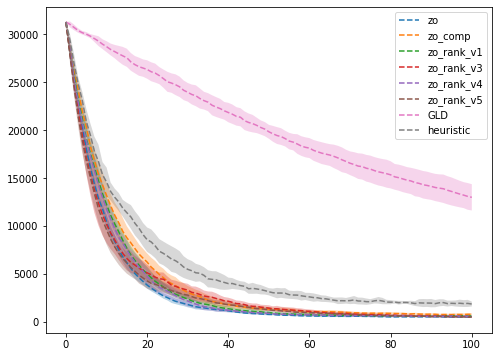

In [21]:
plt.figure(figsize=(8,6))

#plot_hist(fo_total_hist,"fo")
plot_hist(zo_total_hist,"zo")
plot_hist(zo_comp_total_hist,"zo_comp")
plot_hist(zo_rank_v1_total_hist,"zo_rank_v1")
#plot_hist(zo_rank_v2_total_hist,"zo_rank_v2")
plot_hist(zo_rank_v3_total_hist,"zo_rank_v3")
plot_hist(zo_rank_v4_total_hist,"zo_rank_v4")
plot_hist(zo_rank_v5_total_hist,"zo_rank_v5")

plot_hist(gld_total_hist,"GLD")
plot_hist(heuristic_total_hist,"heuristic")
#plot_hist(es_total_hist,"CMA-ES")


plt.legend()